# Section 3.2 Convolutional Neural Network

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Input, Dropout

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Load data
X_train = pd.read_csv('Data/Splitting/Generic/X_train.csv')
y_train_FSO = pd.read_csv('Data/Splitting/Generic/y_train_FSO.csv')
y_train_RF = pd.read_csv('Data/Splitting/Generic/y_train_RF.csv')

X_val = pd.read_csv('Data/Splitting/Generic/X_val.csv')
y_val_FSO = pd.read_csv('Data/Splitting/Generic/y_val_FSO.csv')
y_val_RF = pd.read_csv('Data/Splitting/Generic/y_val_RF.csv')

In [18]:
# One-hot encoding categorical features
categorical_columns = ['Hour', 'Freq', 'SC']
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(X_train[categorical_columns])

# Drop original categorical columns and add encoded columns
X_train = X_train.drop(categorical_columns, axis=1)
X_train = np.concatenate([X_train, encoded_cats], axis=1)

# Apply the same encoding to validation data
encoded_cats_val = encoder.transform(X_val[categorical_columns])
X_val = X_val.drop(categorical_columns, axis=1)
X_val = np.concatenate([X_val, encoded_cats_val], axis=1)

In [19]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [20]:
# Reshape data for CNN input (e.g., add a channel dimension)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [21]:
def rmse(y_true, y_pred):
    '''
    Calculate the Root Mean Squared Error (RMSE).
    '''
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [22]:
def r2_score(y_true, y_pred):
    '''
    Calculate the R² score.
    '''
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

In [23]:
def build_cnn_model(X_train, y_train, X_val, y_val, 
                    filters=(32, 64), kernel_size=3, pool_size=2, 
                    dense_units=(128,), dropout_rate=0.5, 
                    learning_rate=0.001, activation='relu', epochs=50):
    """
    Build, train, and evaluate a Convolutional Neural Network (CNN).

    Parameters:
    - X_train, y_train: Training dataset
    - X_val, y_val: Validation dataset
    - filters: Tuple of filter sizes for each Conv1D layer
    - kernel_size: Size of the convolution kernel (default: 3)
    - pool_size: Size of the MaxPooling window (default: 2)
    - dense_units: Tuple of units in each Dense layer
    - dropout_rate: Dropout rate for regularization (default: 0.5)
    - learning_rate: Learning rate for the optimizer (default: 0.001)
    - activation: Activation function for Conv1D and Dense layers (default: 'relu')
    - epochs: Number of epochs for training (default: 50)

    Returns:
    - model: Trained Keras model
    - final_metrics: Dictionary of final training and validation metrics
    - history: Full training history
    """
    # Build the CNN model
    model = Sequential()

    # Input and first convolutional layer
    model.add(Conv1D(filters=filters[0], kernel_size=kernel_size, 
                     activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(BatchNormalization())

    # Additional convolutional layers
    for f in filters[1:]:
        model.add(Conv1D(filters=f, kernel_size=kernel_size, activation=activation))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(BatchNormalization())

    # Flatten the convolutional output
    model.add(Flatten())

    # Fully connected layers
    for units in dense_units:
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))

    # Output layer for regression
    model.add(Dense(1, activation='linear'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[rmse, r2_score])

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                        validation_data=(X_val, y_val), verbose=0)

    # Extract final metrics
    final_epoch = epochs - 1
    final_metrics = {
        "Training Loss": history.history['loss'][final_epoch],
        "Validation Loss": history.history['val_loss'][final_epoch],
        "Training RMSE": history.history['rmse'][final_epoch],
        "Validation RMSE": history.history['val_rmse'][final_epoch],
        "Training R²": history.history['r2_score'][final_epoch],
        "Validation R²": history.history['val_r2_score'][final_epoch]
    }

    return model, final_metrics, history.history


In [24]:
def cnn_gridsearch(X_train, y_train, X_val, y_val, epochs=50,
                   filter_options=[32, 64],
                   num_conv_layers_options=[2],
                   activation_options=['relu'],
                   learning_rate_options=[0.01],
                   dropout_rate_options=[0.3, 0.5]):
    """
    Perform a grid search to tune CNN hyperparameters.

    Parameters:
    - X_train, y_train: Training dataset
    - X_val, y_val: Validation dataset
    - epochs: Number of epochs for training (default: 50)
    - filter_options: List of filter sizes to explore (default: [32, 64])
    - num_conv_layers_options: List of numbers of convolutional layers to explore (default: [2])
    - activation_options: List of activation functions to explore (default: ['relu'])
    - learning_rate_options: List of learning rates to explore (default: [0.01])
    - dropout_rate_options: List of dropout rates to explore (default: [0.3, 0.5])

    Returns:
    - results_df: DataFrame summarizing performance metrics for each configuration
    - models: List of trained models
    - histories: List of training histories
    """
    results = []  # To store the results for each configuration
    histories = []  # To store training histories
    models = []  # To store trained models

    # Fixed parameters
    kernel_size = 3  # Size of the convolutional kernel
    pool_size = 2  # Size of the max pooling window
    dense_units = (128,)  # Fully connected layer units

    # Perform grid search over hyperparameters
    for num_conv_layers in num_conv_layers_options:
        # Generate combinations of filter sizes for the number of layers
        filters_combinations = list(product(filter_options, repeat=num_conv_layers))

        for filters in filters_combinations:
            for activation in activation_options:
                for learning_rate in learning_rate_options:
                    for dropout_rate in dropout_rate_options:
                        print(f"\nTraining CNN with Filters: {filters}, Conv Layers: {num_conv_layers}, "
                              f"Activation: {activation}, Learning Rate: {learning_rate}, Dropout: {dropout_rate}")

                        # Build and train the CNN model
                        model, final_metrics, history = build_cnn_model(
                            X_train=X_train, y_train=y_train,
                            X_val=X_val, y_val=y_val,
                            filters=filters, kernel_size=kernel_size, pool_size=pool_size,
                            dense_units=dense_units, dropout_rate=dropout_rate,
                            learning_rate=learning_rate, activation=activation, epochs=epochs
                        )

                        # Store the model and its history
                        models.append(model)
                        histories.append({
                            'history': history,
                            'Model Name': f"CNN-{filters}-{activation}-{learning_rate}-Dropout{dropout_rate}"
                        })

                        # Store the result metrics
                        result = {
                            'Model Name': f"CNN-{filters}-{activation}-{learning_rate}-Dropout{dropout_rate}",
                            'Filters': filters,
                            'Conv Layers': num_conv_layers,
                            'Activation': activation,
                            'Learning Rate': learning_rate,
                            'Dropout Rate': dropout_rate,
                            'Training Loss': final_metrics["Training Loss"],
                            'Validation Loss': final_metrics["Validation Loss"],
                            'Training RMSE': final_metrics["Training RMSE"],
                            'Validation RMSE': final_metrics["Validation RMSE"],
                            'Training R²': final_metrics["Training R²"],
                            'Validation R²': final_metrics["Validation R²"]
                        }
                        results.append(result)

    # Convert results to a DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Return results and models
    return results_df, models, histories

In [25]:
def plot_best_models(results_df, histories, top_num=3):
    """
    Plot the training and validation metrics for the top models.

    Parameters:
    - results_df: DataFrame containing model configurations and their performance metrics.
    - histories: List of dictionaries with training history and model names.
    - top_num: Number of top models to plot based on Validation R² and Validation RMSE.

    Returns:
    - None. Displays the plots for the top models.
    """
    # Sort by highest Validation R² and lowest Validation RMSE
    top_models = results_df.sort_values(by=['Validation R²', 'Validation RMSE'], 
                                        ascending=[False, True]).head(top_num)
    
    print(f"\nTop {top_num} Model Configurations with Highest Validation R² and Lowest Validation RMSE:")
    try:
        display(top_models)  # For Jupyter Notebooks
    except NameError:
        print(top_models)  # For non-Jupyter environments
    
    # Create subplots for metric curves
    num_top_models = len(top_models)
    fig, axes = plt.subplots(num_top_models, 1, figsize=(12, num_top_models * 4))
    
    # Handle single subplot case
    if num_top_models == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, top_models.iterrows()):
        # Find the matching history for the current top model
        matching_history = next(
            (h['history'] for h in histories if h['Model Name'] == row['Model Name']),
            None
        )
        
        if matching_history is None:
            print(f"No matching history found for model: {row['Model Name']}")
            continue
        
        # Plot metrics
        ax.plot(matching_history['loss'], label='Training Loss', linestyle='--')
        ax.plot(matching_history['val_loss'], label='Validation Loss', linestyle='-')
        ax.plot(matching_history['rmse'], label='Training RMSE', linestyle='--')
        ax.plot(matching_history['val_rmse'], label='Validation RMSE', linestyle='-')
        ax.plot(matching_history['r2_score'], label='Training R²', linestyle='--')
        ax.plot(matching_history['val_r2_score'], label='Validation R²', linestyle='-')
        ax.set_title(f"Metrics for Top Model: {row['Model Name']}", fontsize=14)
        ax.set_xlabel('Epochs', fontsize=12)
        ax.set_ylabel('Metrics', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


In [26]:
def save_best_model(results_df, models, histories, nntype, channel):
    """
    Save the best model based on Validation R² and RMSE.

    Parameters:
    - results_df: DataFrame containing model configurations and their performance metrics.
    - models: List of trained models corresponding to the results_df rows.
    - histories: List of training histories corresponding to the models.
    - nntype: A string indicating the type of neural network (e.g., 'ANN', 'CNN').

    Returns:
    - model_save_path: The file path where the best model was saved.
    """
    # Sort by highest Validation R² and lowest Validation RMSE
    top_model_index = results_df.sort_values(
        by=['Validation R²', 'Validation RMSE'], ascending=[False, True]
    ).index[0]  # Get the index of the best model
    
    # Retrieve the best model and its details
    best_model = models[top_model_index]
    best_result = results_df.iloc[top_model_index]
    best_history = histories[top_model_index]['history']
    
    # Ensure the directory for saved models exists
    os.makedirs("saved_models", exist_ok=True)
    
    # Save the best model
    model_save_path = f"saved_models/{channel}_best_{nntype}_model.h5"
    save_model(best_model, model_save_path)
    print(f"\nBest {nntype} model saved to: {model_save_path}")
    
    # Print details of the best model
    print(f"\nBest {nntype} Model Details:")
    print(best_result)
    
    return model_save_path


In [29]:
# Define hyperparameters for the CNN grid search
filter_options = [128, 256]
num_conv_layers_options = [2, 3]
activation_options = ['relu', 'tanh', 'sigmoid']
learning_rate_options = [0.01, 0.001]
dropout_rate_options=[0.3]

In [30]:
cnn_FSO_results, cnn_FSO_models, cnn_FSO_histories = cnn_gridsearch(
    X_train=X_train, 
    y_train=y_train_FSO, 
    X_val=X_val, 
    y_val=y_val_FSO, 
    epochs=50,
    filter_options=filter_options,
    num_conv_layers_options=num_conv_layers_options,
    activation_options=activation_options,
    learning_rate_options=learning_rate_options,
    dropout_rate_options=dropout_rate_options
)


Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: relu, Learning Rate: 0.01, Dropout: 0.3

Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: relu, Learning Rate: 0.001, Dropout: 0.3

Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: tanh, Learning Rate: 0.01, Dropout: 0.3

Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: tanh, Learning Rate: 0.001, Dropout: 0.3

Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: sigmoid, Learning Rate: 0.01, Dropout: 0.3

Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: sigmoid, Learning Rate: 0.001, Dropout: 0.3

Training CNN with Filters: (128, 256), Conv Layers: 2, Activation: relu, Learning Rate: 0.01, Dropout: 0.3

Training CNN with Filters: (128, 256), Conv Layers: 2, Activation: relu, Learning Rate: 0.001, Dropout: 0.3

Training CNN with Filters: (128, 256), Conv Layers: 2, Activation: tanh, Learning Rate: 0.01, Dropout: 0.3

Training CNN with


Top 5 Model Configurations with Highest Validation R² and Lowest Validation RMSE:


,Model Name,Filters,Conv Layers,Activation,Learning Rate,Dropout Rate,Training Loss,Validation Loss,Training RMSE,Validation RMSE,Training R²,Validation R²
35,"CNN-(128, 128, 256)-sigmoid-0.001-Dropout0.3","(128, 128, 256)",3,sigmoid,0.001,0.3,0.832334,0.913017,0.886121,0.925186,0.939773,0.930894
29,"CNN-(128, 128, 128)-sigmoid-0.001-Dropout0.3","(128, 128, 128)",3,sigmoid,0.001,0.3,0.902294,0.955474,0.922297,0.939153,0.934870,0.929099
55,"CNN-(256, 128, 256)-relu-0.001-Dropout0.3","(256, 128, 256)",3,relu,0.001,0.3,1.001689,0.974884,0.972980,0.953486,0.927365,0.927906
41,"CNN-(128, 256, 128)-sigmoid-0.001-Dropout0.3","(128, 256, 128)",3,sigmoid,0.001,0.3,0.941614,0.968448,0.939785,0.954400,0.931576,0.927314
67,"CNN-(256, 256, 256)-relu-0.001-Dropout0.3","(256, 256, 256)",3,relu,0.001,0.3,0.944675,0.981272,0.943665,0.952836,0.931774,0.926966


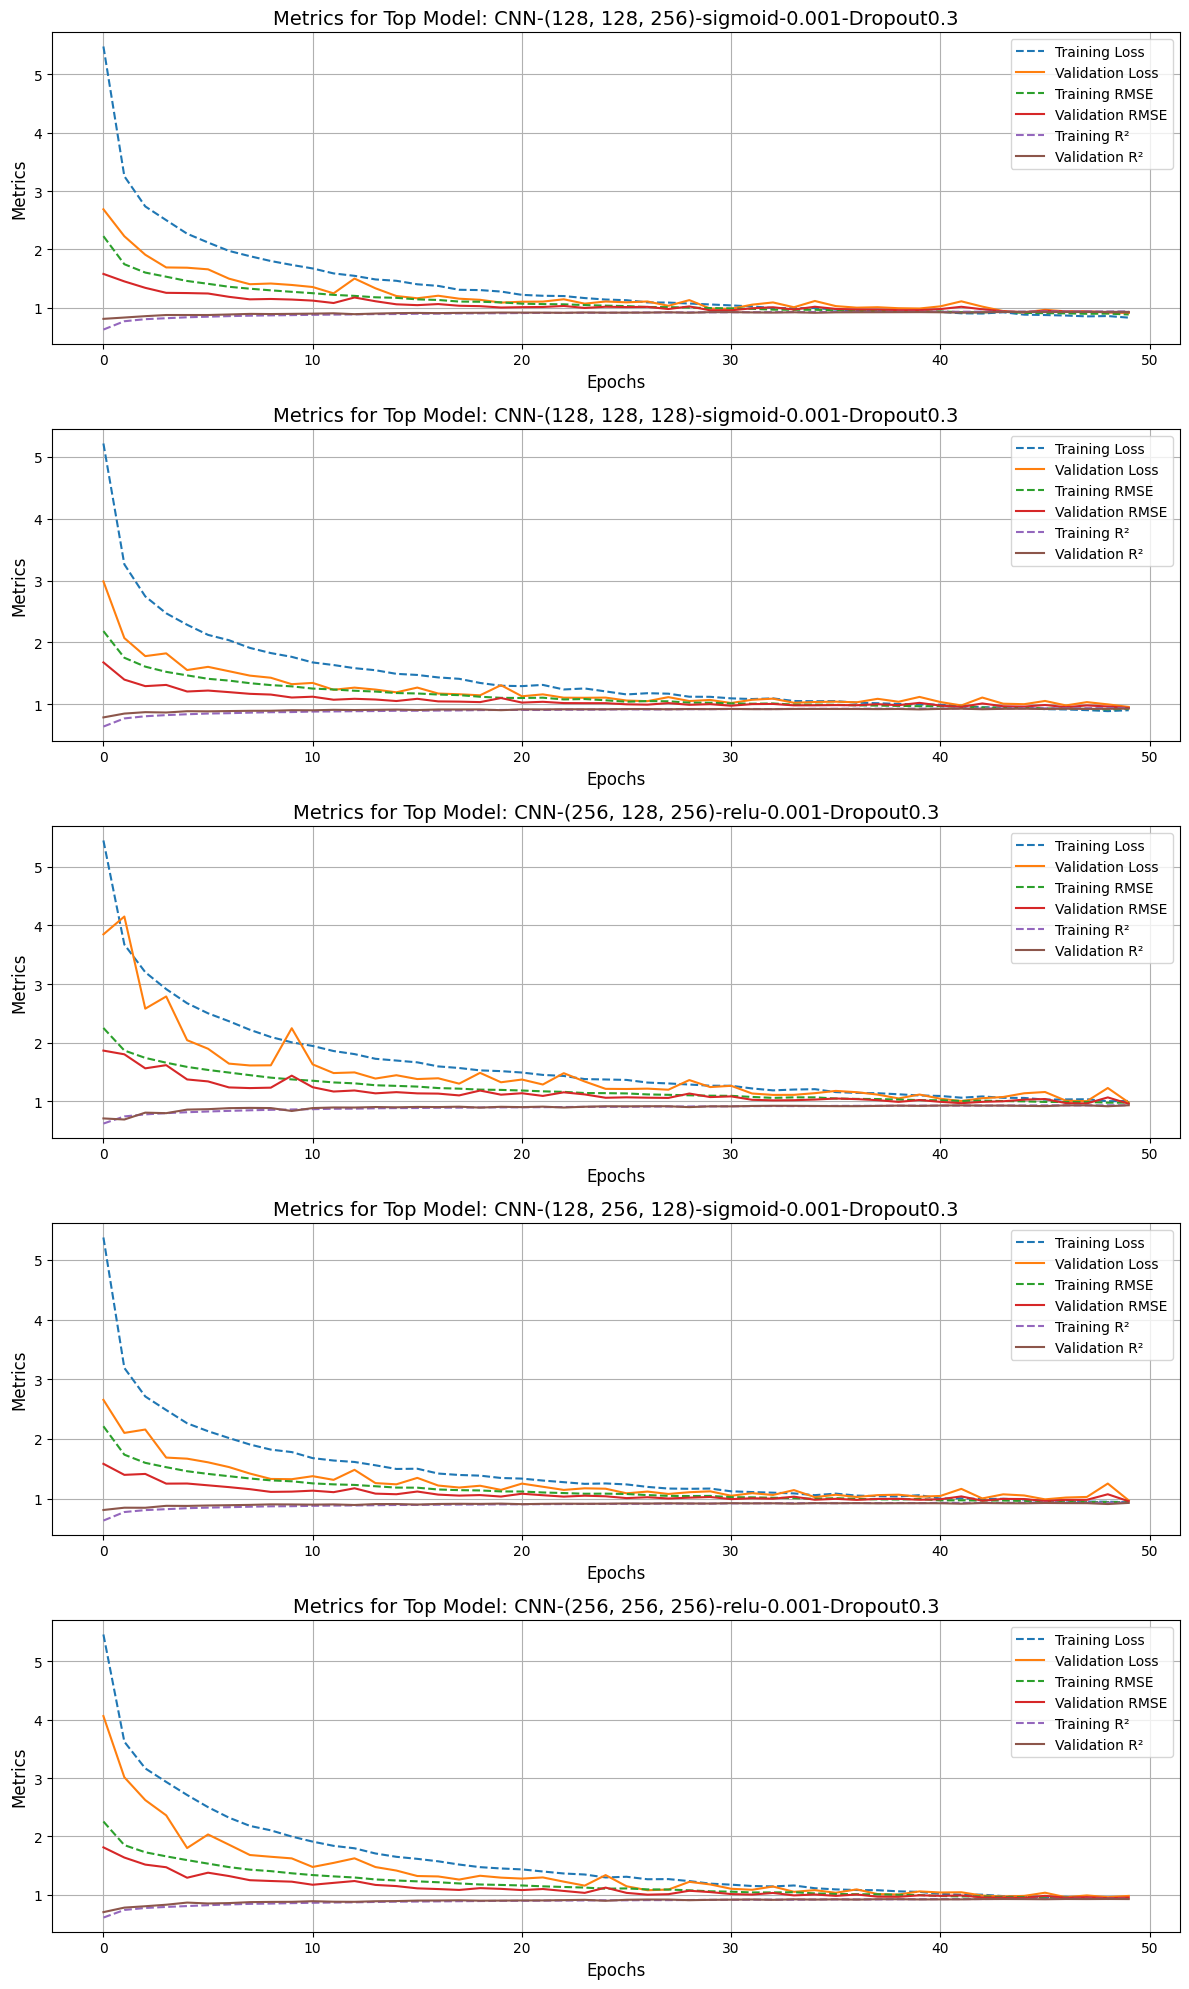

In [31]:
plot_best_models(cnn_FSO_results, cnn_FSO_histories, top_num=5)

In [32]:
save_best_model(cnn_FSO_results, cnn_FSO_models, cnn_FSO_histories, "CNN","FSO")


Best CNN model saved to: saved_models/FSO_best_CNN_model.h5

Best CNN Model Details:
Model Name         CNN-(128, 128, 256)-sigmoid-0.001-Dropout0.3
Filters                                         (128, 128, 256)
Conv Layers                                                   3
Activation                                              sigmoid
Learning Rate                                             0.001
Dropout Rate                                                0.3
Training Loss                                          0.832334
Validation Loss                                        0.913017
Training RMSE                                          0.886121
Validation RMSE                                        0.925186
Training R²                                            0.939773
Validation R²                                          0.930894
Name: 35, dtype: object


'saved_models/FSO_best_CNN_model.h5'

In [33]:
cnn_RF_results, cnn_RF_models, cnn_RF_histories = cnn_gridsearch(
    X_train=X_train, 
    y_train=y_train_RF, 
    X_val=X_val, 
    y_val=y_val_RF, 
    epochs=50,
    filter_options=filter_options,
    num_conv_layers_options=num_conv_layers_options,
    activation_options=activation_options,
    learning_rate_options=learning_rate_options,
    dropout_rate_options=dropout_rate_options
)


Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: relu, Learning Rate: 0.01, Dropout: 0.3

Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: relu, Learning Rate: 0.001, Dropout: 0.3

Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: tanh, Learning Rate: 0.01, Dropout: 0.3

Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: tanh, Learning Rate: 0.001, Dropout: 0.3

Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: sigmoid, Learning Rate: 0.01, Dropout: 0.3

Training CNN with Filters: (128, 128), Conv Layers: 2, Activation: sigmoid, Learning Rate: 0.001, Dropout: 0.3

Training CNN with Filters: (128, 256), Conv Layers: 2, Activation: relu, Learning Rate: 0.01, Dropout: 0.3

Training CNN with Filters: (128, 256), Conv Layers: 2, Activation: relu, Learning Rate: 0.001, Dropout: 0.3

Training CNN with Filters: (128, 256), Conv Layers: 2, Activation: tanh, Learning Rate: 0.01, Dropout: 0.3

Training CNN with


Top 5 Model Configurations with Highest Validation R² and Lowest Validation RMSE:


,Model Name,Filters,Conv Layers,Activation,Learning Rate,Dropout Rate,Training Loss,Validation Loss,Training RMSE,Validation RMSE,Training R²,Validation R²
43,"CNN-(128, 256, 256)-relu-0.001-Dropout0.3","(128, 256, 256)",3,relu,0.001,0.3,0.456632,0.432646,0.634750,0.586408,0.957632,0.962392
49,"CNN-(256, 128, 128)-relu-0.001-Dropout0.3","(256, 128, 128)",3,relu,0.001,0.3,0.507384,0.447962,0.667547,0.596623,0.952279,0.961963
31,"CNN-(128, 128, 256)-relu-0.001-Dropout0.3","(128, 128, 256)",3,relu,0.001,0.3,0.455309,0.435891,0.638659,0.592997,0.956650,0.961791
61,"CNN-(256, 256, 128)-relu-0.001-Dropout0.3","(256, 256, 128)",3,relu,0.001,0.3,0.461064,0.488023,0.637081,0.610464,0.957457,0.960722
37,"CNN-(128, 256, 128)-relu-0.001-Dropout0.3","(128, 256, 128)",3,relu,0.001,0.3,0.465909,0.438240,0.639348,0.590798,0.957182,0.960260


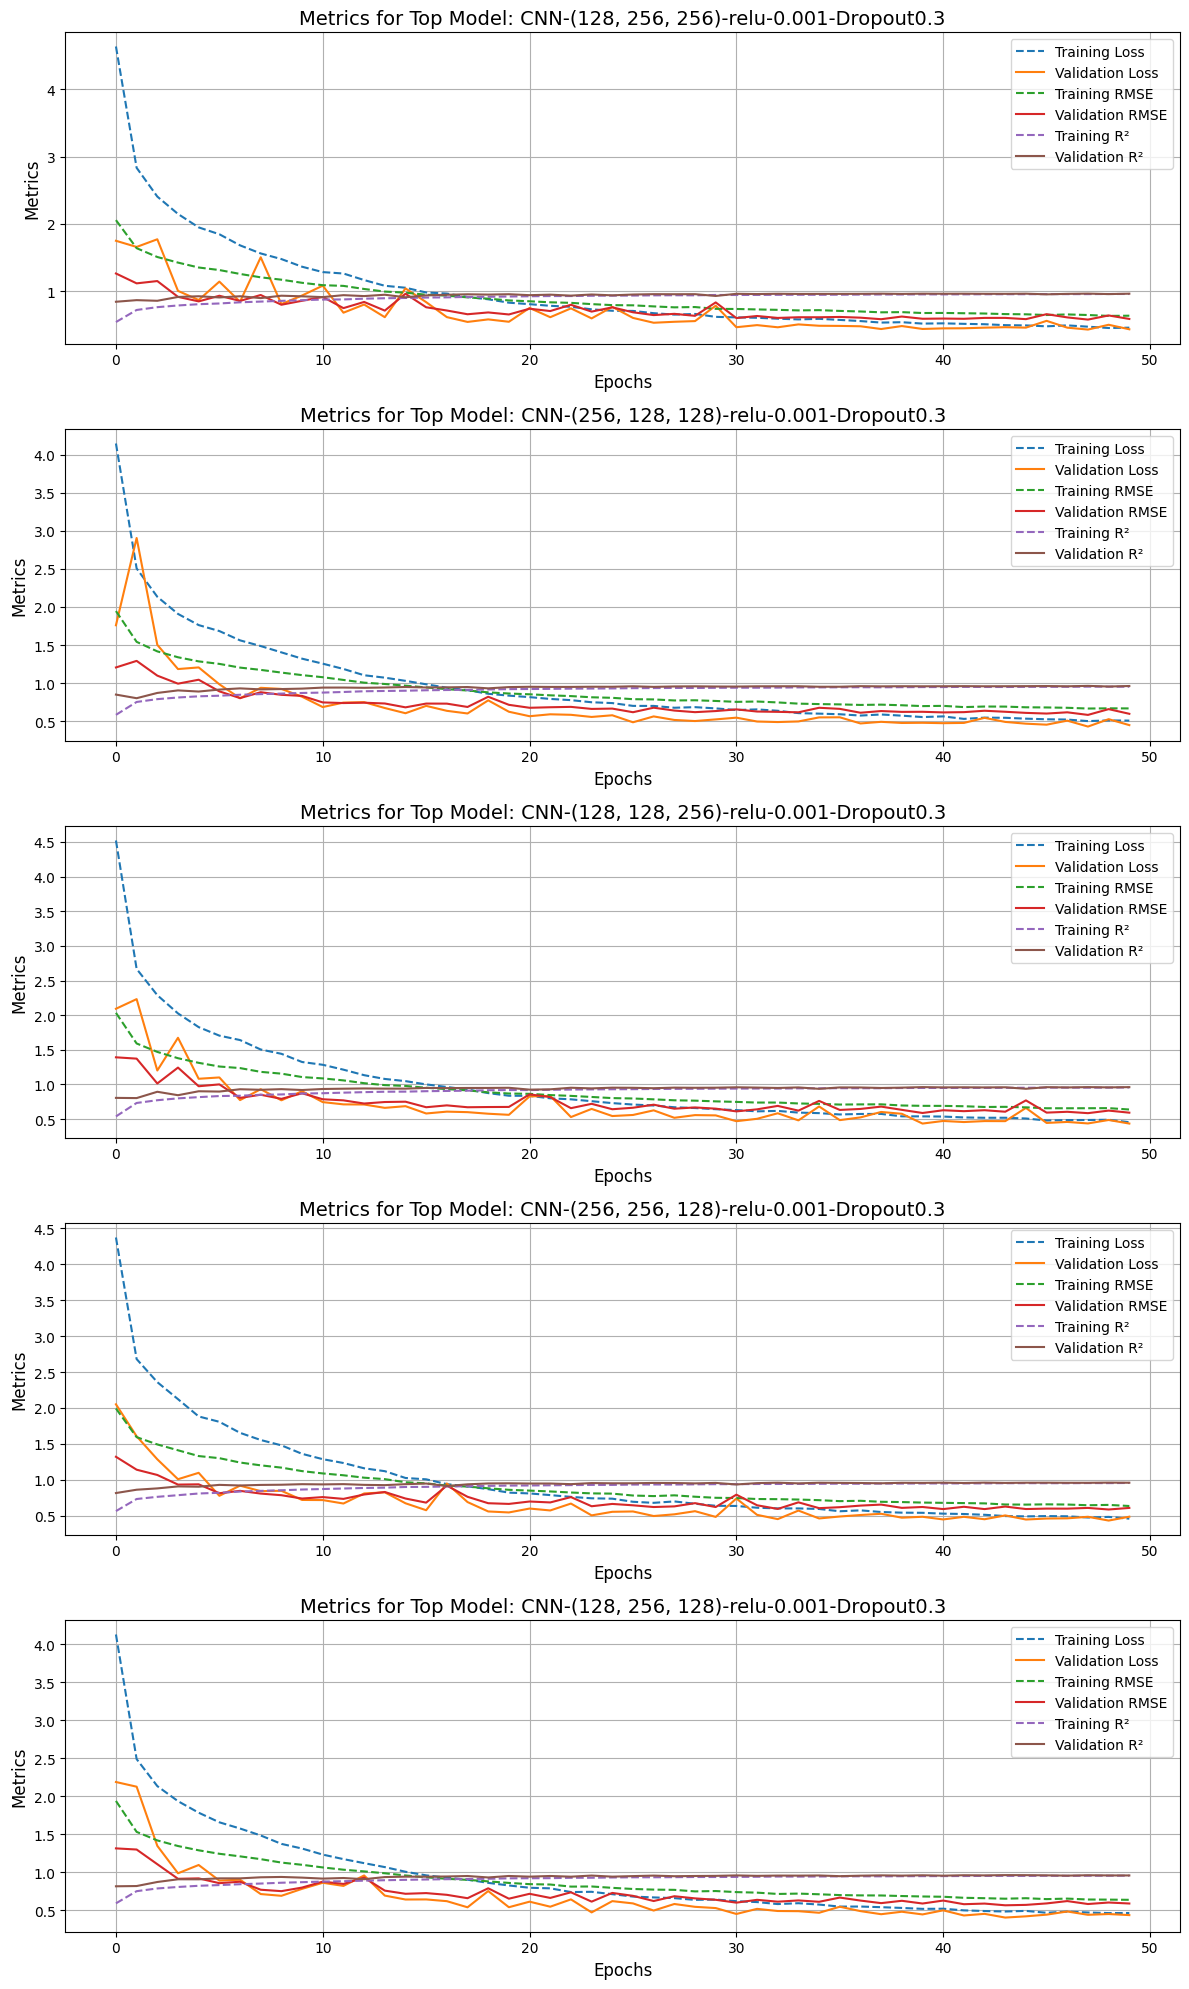

In [34]:
plot_best_models(cnn_RF_results, cnn_RF_histories, top_num=5)

In [35]:
save_best_model(cnn_RF_results, cnn_RF_models, cnn_RF_histories, "CNN","RF")


Best CNN model saved to: saved_models/RF_best_CNN_model.h5

Best CNN Model Details:
Model Name         CNN-(128, 256, 256)-relu-0.001-Dropout0.3
Filters                                      (128, 256, 256)
Conv Layers                                                3
Activation                                              relu
Learning Rate                                          0.001
Dropout Rate                                             0.3
Training Loss                                       0.456632
Validation Loss                                     0.432646
Training RMSE                                        0.63475
Validation RMSE                                     0.586408
Training R²                                         0.957632
Validation R²                                       0.962392
Name: 43, dtype: object


'saved_models/RF_best_CNN_model.h5'